In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rc
import numpy as np
from math import pi
import os

rc("font", **{"family": "serif", "serif": ["Times"], "size": 9})
rc("text", usetex=True)

SINGLE_WIDTH = 246 / 72
DOUBLE_WIDTH = 510 / 72
GOLDEN_RATIO = (5**0.5 - 1) / 2
DATA_DIR = "../data"
SAVE_FIG = True
SAVE_DIR = "../figs"

In [2]:
import pandas as pd
import json
import tarfile


def extract(tar_filename, target_dir):
    file = tarfile.open(tar_filename)
    file.extractall(target_dir)
    file.close()


def import_data(dir):
    data = []
    for d in os.listdir(dir):
        if not os.path.isdir(f"{dir}/{d}"):
            continue
        for f in os.listdir(f"{dir}/{d}"):
            if ".json" in f:
                with open(f"{dir}/{d}/{f}", "r") as file:
                    contents = file.read()
                    contents = contents.replace(",\n}", "\n}")
                    results = json.loads(contents)

                    results.get(
                        "t_count",
                        (
                            results["num_gates"].get("t", 0)
                            + results["num_gates"].get("tdg", 0)
                            if results.get("num_gates", None) is not None
                            else None
                        ),
                    )
                    results["total_count"] = (
                        sum(list(results["num_gates"].values()))
                        - results["num_gates"].get("barrier", 0)
                        if results.get("num_gates", None) is not None
                        else None
                    )
                    results["clifford_count"] = (
                        results["qasm"].count("h qubits")
                        + results["qasm"].count("s qubits")
                        + results["qasm"].count("sdg qubits")
                        + results["qasm"].count("sx qubits")
                        if results.get("qasm", None) is not None
                        else None
                    )
                    if "num_nontrivial_rotations" in results:
                        results["t_count_per_angle"] = (
                            results["t_count"] / results["num_nontrivial_rotations"]
                            if results["t_count"] is not None
                            else None
                        )
                    results["name"] = (
                        results["benchmark_id"]
                        .replace("_transpiled_u3", "")
                        .replace("_transpiled_rz", "")
                        .replace("_", " ")
                    )
                    data.append(results)
    df = pd.DataFrame(data)
    df.sort_values(by=["epsilon"], inplace=True, ascending=False)
    return df

Single-Qubit Unitary Synthesis

In [202]:
extract(
    "../data/random_unitary/synthetiq/synthetiq-3-6-hstxyz.tar.gz",
    "../data/random_unitary/synthetiq/synthetiq-3-6-hstxyz",
)

[   1  931 1000]


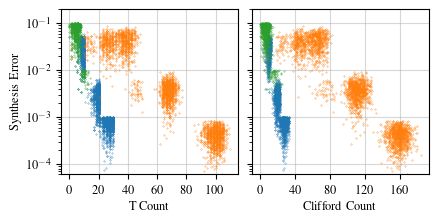

In [ ]:
import json
import os
from math import pi
from time import time

import numpy as np
import matplotlib.pyplot as plt

seed_pool = range(1000)

data = {"t_count": [], "error": [], "clifford_count": [], "time": []}
for algorithm in ["trasyn_tshxyz_tb10_ns40000", "gridsynth"]:
    for key, value in data.items():
        data[key].append([])
    for seed in seed_pool:
        with open(
            (f"../data/random_unitary/{algorithm}/{algorithm}_s{seed}" + ".json"),
            "r",
        ) as f:
            datafile = json.load(f)["data"]
        for d in datafile:
            d["clifford_count"] = d["seqstr"].count("s") + d["seqstr"].count("h")
        for key, value in data.items():
            data[key][-1].append([d[key] for d in datafile[:3]])

synthetiq = import_data("../data/random_unitary/synthetiq/synthetiq-3-6-hstxyz")
for key, value in data.items():
    data[key] = np.concatenate(
        [
            np.array(value),
            np.array(synthetiq[key][: 3 * len(list(seed_pool))])
            .reshape(1, 3, -1)
            .transpose(0, 2, 1),
        ],
        axis=0,
    )
print(np.isnan(data["t_count"][2]).sum(axis=0))

fig, ax = plt.subplots(
    1,
    2,
    figsize=(SINGLE_WIDTH * 1.25, SINGLE_WIDTH * GOLDEN_RATIO * 1),
    sharey=True,
    layout="constrained",
)
for i, label in enumerate(("T Count", "Clifford Count")):
    metric = data[label.lower().replace(" ", "_")]
    for j, (algorithm, color) in enumerate(
        zip(
            ["trasyn", "gridsynth", "synthetiq"],
            ["tab:blue", "tab:orange", "tab:green"],
        )
    ):
        ax[i].semilogy(
            metric[j].flat,
            data["error"][j].flat,
            marker=".",
            markersize=0.5,
            linestyle="None",
            # alpha=0.7,
            color=color,
        )
        if i == 0:
            ax[i].semilogy(
                np.nan,
                np.nan,
                marker=".",
                markersize=5,
                linestyle="None",
                label=f"\\textsc{{{algorithm}}}",
                color=color,
            )
        ax[i].set_xticks(range(0, 110 + 70 * i, 20 * (i + 1)))
    ax[i].grid(alpha=0.5)
    ax[i].set_xlabel(label)
x = np.arange(0, 50)
# ax[0].plot(
#     x,
#     2 ** ((-x - 9.0) / 4),
#     label="Worst-Case\n$T$ Bound",
#     color="tab:red",
#     linestyle="--",
#     linewidth=1,
# )
# ax[0].plot(
#     x,
#     2 ** ((-x - 18.0) / 3),
#     label="Typical-Case\n$T$ Bound",
#     color="tab:purple",
#     linestyle="--",
#     linewidth=1,
# )
# ax[0].plot(x, 2 ** ((-x - 9.) / 4), label=r"$\# T=4\log_2 1 / \epsilon - 9$")
# ax[0].plot(x, 2 ** ((-x - 16.) / 3), label=r"$\# T=3\log_2 1 / \epsilon - 16$")
ax[0].legend(
    loc="upper right",
    markerscale=1,
    fontsize=8,
    handletextpad=0.5,
    labelspacing=0.4,
    # borderpad=0.2,
    borderaxespad=0.1,
)
# ax[1].legend(
#     loc="upper right",
#     markerscale=1,
#     fontsize=8,
#     handletextpad=0.5,
#     labelspacing=0.4,
#     borderaxespad=0.1,
# )
ax[0].set_ylabel("Synthesis Error")
ax[0].set_ylim(6e-5, 0.2)
if SAVE_FIG:
    fig.savefig(f"{SAVE_DIR}/random_unitary.pdf")

In [28]:
def geomean(x):
    return np.exp(np.mean(np.log(x)))

for i, label in enumerate(("T Count", "Clifford Count")):
    print("\\midrule")
    print(label, end="")
    metric = data[label.lower().replace(" ", "_")]
    values = metric[1, :, -1] / metric[0, :, -1]
    for eval in (np.min, np.mean, geomean, np.median, np.max):
        print(" &", round(eval(values), 2), end="x")
    print("\\\\")

\midrule
T Count & 2.31x & 3.76x & 3.74x & 3.68x & 6.12x\\
\midrule
Clifford Count & 3.39x & 5.77x & 5.73x & 5.66x & 9.41x\\


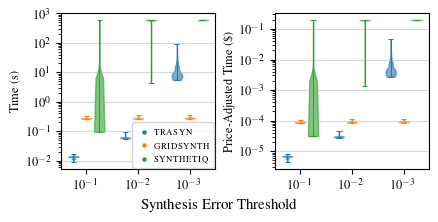

In [33]:
fig, ax = plt.subplots(
    1,
    2,
    figsize=(SINGLE_WIDTH * 1.25, SINGLE_WIDTH * GOLDEN_RATIO * 1),
    sharey=False,
    layout="constrained",
)
for i, (metric, label) in enumerate(
    zip((data["time"], data["time"]), ("Time (s)", "Price-Adjusted Time (\$)"))
):
    for j, (algorithm, color) in enumerate(
        zip(
            ["trasyn", "gridsynth", "synthetiq"],
            ["tab:blue", "tab:orange", "tab:green"],
        )
    ):
        ax[i].scatter(
            np.nan, np.nan, label=f"\\textsc{{{algorithm}}}", color=color, s=5
        )
        if i == 1:
            if j == 0:
                scale = 1.79 / 3600
            else:
                scale = 1.18 / 3600
        else:
            scale = 1
        for k in range(3):
            violin_parts = ax[i].violinplot(
                metric[j, :, k] * scale,
                positions=[k + j * 0.25],
                widths=0.2,
                # patch_artist=True,
                # boxprops={"facecolor": color},
            )
            for key, value in violin_parts.items():
                if key == "bodies":
                    for pc in value:
                        pc.set_color(color)
                        pc.set_alpha(0.6)
                else:
                    value.set_color(color)
                    value.set_linewidth(0.75)
    ax[i].set_xticks([0.25, 1.25, 2.25], labels=[f"$10^{{{-e}}}$" for e in range(1, 4)])
    ax[i].semilogy()
    ax[i].set_ylabel(label)
    ax[i].grid(axis="y", alpha=0.5, zorder=0)
ax[0].legend(
    loc="lower right",
    fontsize=8,
    handlelength=1.5,
    handletextpad=0.1,
    labelspacing=0.3,
    borderaxespad=0.1,
)
fig.supxlabel("Synthesis Error Threshold")
if SAVE_FIG:
    fig.savefig(f"{SAVE_DIR}/random_unitary_time.pdf")

Logical Error Rate vs Synthesis Error Threshold (1q)

[1.22214923] [[1.71505589e-05]]


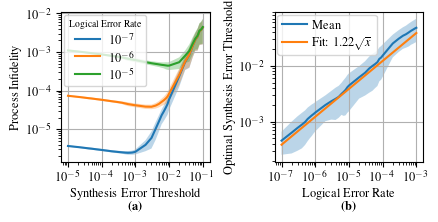

In [29]:
from matplotlib.ticker import LogLocator
from scipy.optimize import curve_fit

from utils import find_json_to_read

algorithm = "gridsynth_t_only"

fig, ax = plt.subplots(
    1,
    2,
    figsize=(SINGLE_WIDTH * 1.25, SINGLE_WIDTH * GOLDEN_RATIO * 1),
    sharey=False,
    layout="constrained",
)
fidelity, synthesis_errors = [], []
for i, (_, row) in enumerate(
    find_json_to_read(f"{DATA_DIR}/logical_error/1q/{algorithm}")
):
    fidelity.append(row["fidelity"])
    synthesis_errors.append(row["synthesis_errors"])
logical_errors = row["logical_errors"]
synthesis_thresholds = row["synthesis_thresholds"]
logical_ticks = [f"$10^{{{int(np.log10(e))}}}$" for e in row["logical_errors"][::9]]
synthesis_ticks = [
    f"$10^{{{int(np.log10(e))}}}$" for e in row["synthesis_thresholds"][::9]
]
fidelity = (
    np.array(fidelity)
    .reshape(-1, len(synthesis_thresholds), len(logical_errors))
    .transpose(0, 2, 1)
)
synthesis_errors = np.array(synthesis_errors).reshape(-1, len(synthesis_thresholds))

for i in range(3):
    y = 1 - fidelity[:, i * 10]
    mean = y.mean(axis=0)
    std = y.std(axis=0)
    ax[0].loglog(
        synthesis_thresholds,
        mean,
        # fmt='o',
        label=logical_ticks[i],
    )
    ax[0].fill_between(
        synthesis_thresholds,
        mean - std,
        mean + std,
        alpha=0.3,
    )
ax[0].set_xlabel("Synthesis Error Threshold\n$\\textbf{(a)}$")
ax[0].set_ylabel("Process Infidelity")
ax[0].set_xticks(synthesis_thresholds[::9])
ax[0].xaxis.set_minor_locator(LogLocator(subs="all", numticks=10))
ax[0].grid()
ax[0].legend(
    loc="upper left", title="Logical Error Rate", title_fontsize=7, borderaxespad=0.2
)
# ax[0].set_ylim(4e-6, 1e-2)


def func(x, a):
    return 0.5 * x + np.log(a)


# y = np.array(synthesis_errors).flatten()[np.argmax(fidelity, axis=2).flatten()].reshape(
#     fidelity.shape[0], -1
# )
# print(y)
y = np.array(synthesis_thresholds)[np.argmax(fidelity, axis=2)]
popt, pcov = curve_fit(
    func,
    np.log(np.tile(logical_errors, fidelity.shape[0])),
    np.log(y.reshape(-1)),
    p0=[2],
)
print(popt, pcov)
mean = y.mean(axis=0)
std = y.std(axis=0)
ax[1].loglog(logical_errors, mean, label="Mean")
ax[1].fill_between(logical_errors, mean - std, mean + std, alpha=0.3)
# ax[1].scatter(
#     np.tile(logical_errors, fidelity.shape[0]),
#     y.flatten(),
#     s=1,
#     alpha=0.5,
# )
ax[1].loglog(
    logical_errors,
    popt[0] * np.sqrt(logical_errors),
    label=f"Fit: ${popt[0]:.2f}\sqrt{{x}}$",
)
# ax[1].set_ylim(4e-4, 1e-1)
ax[1].set_xticks(logical_errors[::9])
ax[1].xaxis.set_minor_locator(LogLocator(subs="all", numticks=10))
ax[1].grid()
ax[1].set_xlabel("Logical Error Rate\n$\\textbf{(b)}$")
ax[1].set_ylabel("Optimal Synthesis Error Threshold")
ax[1].legend(loc="upper left", borderaxespad=0.2, markerscale=0.5, handletextpad=0.4)
# fig.tight_layout()
if SAVE_FIG:
    fig.savefig(f"{SAVE_DIR}/logical_error_1q_{algorithm}.pdf")

Number of Rotations Rz vs U3

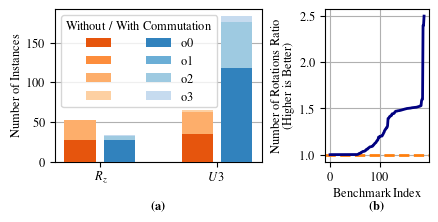

In [5]:
datasets = ["benchpress", "hamlib", "qaoa"]
depth_pool = range(1, 6)
qubit_pool = range(4, 27, 2)
seed_pool = range(10)

datafile = []
for dataset in datasets:
    with open(
        f"{DATA_DIR}/qasm/{dataset}/num_nontrivial_rotations.json",
        "r",
        encoding="utf-8",
    ) as file:
        num_nontrivial_rotations = json.load(file)
    num_rotations = np.array(list(num_nontrivial_rotations.values()))
    if dataset == "qaoa":
        num_rotations = num_rotations.reshape(-1, len(seed_pool), 16).mean(axis=-2)
    datafile.append(num_rotations)
datafile = np.concatenate(datafile, axis=0).reshape(-1, 2, 4, 2)
count = np.zeros((4, 4))
for row in datafile.transpose(0, 1, 3, 2).reshape(-1, 4, 4):
    for i, config in enumerate(row):
        if config.min() == row.min():
            count[i, config[::-1].argmin()] += 1
count = count.T  # .reshape(4, 2, 2)

fig, ax = plt.subplots(
    1,
    2,
    figsize=(1.25 * SINGLE_WIDTH, SINGLE_WIDTH * GOLDEN_RATIO * 1),
    sharey=False,
    layout="constrained",
    gridspec_kw={"width_ratios": [2, 1]},
)
for opt_lvl, config in enumerate(count):
    ax[0].bar(
        [0, 3],
        config[::2],
        label=[f" ", ""],
        zorder=3,
        bottom=count[:opt_lvl].sum(axis=0)[::2],
        color=plt.cm.tab20c(opt_lvl + 4),
    )
for opt_lvl, config in enumerate(count):
    ax[0].bar(
        [1, 4],
        config[1::2],
        label=[f"o{opt_lvl}", ""],
        # label=[f"With Commutation" if opt_lvl == 0 else " ", " "],
        zorder=3,
        bottom=count[:opt_lvl].sum(axis=0)[1::2],
        color=plt.cm.tab20c(opt_lvl),
    )
ax[0].set_ylabel("Number of Instances")
ax[0].set_xlabel("\n$\\textbf{(a)}$")
ax[0].legend(ncols=2, title=r"Without /  With Commutation")
ax[0].set_xticks([0.5, 3.5], labels=["$R_z$", "$U3$"])
ax[0].grid(axis="y", zorder=0.5)

y = np.min(datafile[:, 0], axis=(1, 2)) / np.min(datafile[:, 1], axis=(1, 2))
y = np.sort(y[np.isfinite(y)])
ax[1].axhline(1, linestyle="--", color="tab:orange", linewidth=2)
ax[1].plot(y, color="navy", linewidth=2)
# plt.ylim(0, 6.5)
ax[1].grid()
ax[1].set_xlabel("Benchmark Index\n$\\textbf{(b)}$")
ax[1].set_ylabel("Number of Rotations Ratio\n(Higher is Better)")
# fig.tight_layout()
if SAVE_FIG:
    plt.savefig(f"{SAVE_DIR}/num_rotations.pdf")

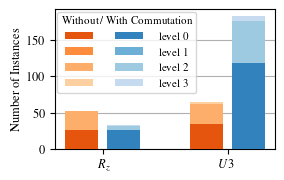

In [ ]:
datasets = ["benchpress", "hamlib", "qaoa"]
depth_pool = range(1, 6)
qubit_pool = range(4, 27, 2)
seed_pool = range(10)

datafile = []
for dataset in datasets:
    with open(
        f"{DATA_DIR}/qasm/{dataset}/num_nontrivial_rotations.json",
        "r",
        encoding="utf-8",
    ) as file:
        num_nontrivial_rotations = json.load(file)
    num_rotations = np.array(list(num_nontrivial_rotations.values()))
    if dataset == "qaoa":
        num_rotations = num_rotations.reshape(-1, len(seed_pool), 16).mean(axis=-2)
    datafile.append(num_rotations)
datafile = np.concatenate(datafile, axis=0).reshape(-1, 2, 4, 2)
count = np.zeros((4, 4))
for row in datafile.transpose(0, 1, 3, 2).reshape(-1, 4, 4):
    for i, config in enumerate(row):
        if config.min() == row.min():
            count[i, config[::-1].argmin()] += 1
count = count.T  # .reshape(4, 2, 2)

fig, ax = plt.subplots(
    1,
    1,
    figsize=(0.8 * SINGLE_WIDTH, 0.8 * SINGLE_WIDTH * GOLDEN_RATIO),
    sharey=False,
    layout="constrained",
)
for opt_lvl, config in enumerate(count):
    ax.bar(
        [0, 3],
        config[::2],
        label=[f" ", ""],
        zorder=3,
        bottom=count[:opt_lvl].sum(axis=0)[::2],
        color=plt.cm.tab20c(opt_lvl + 4),
    )
for opt_lvl, config in enumerate(count):
    ax.bar(
        [1, 4],
        config[1::2],
        label=[f"level {opt_lvl}", ""],
        # label=[f"With Commutation" if opt_lvl == 0 else " ", " "],
        zorder=3,
        bottom=count[:opt_lvl].sum(axis=0)[1::2],
        color=plt.cm.tab20c(opt_lvl),
    )
ax.set_ylabel("Number of Instances")
ax.legend(
    ncols=2,
    title=r"Without /  With Commutation",
    title_fontsize=8,
    loc="upper left",
    borderaxespad=0.2,
    fontsize=8,
    handlelength=2.5,
    handletextpad=1.5,
    columnspacing=0.5,
)
ax.set_xticks([0.5, 3.5], labels=["$R_z$", "$U3$"])
ax.grid(axis="y", zorder=0.5)

if SAVE_FIG:
    plt.savefig(f"{SAVE_DIR}/num_rotations.pdf")

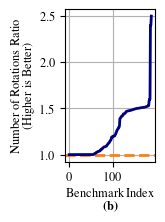

In [14]:
datasets = ["benchpress", "hamlib", "qaoa"]
depth_pool = range(1, 6)
qubit_pool = range(4, 27, 2)
seed_pool = range(10)

datafile = []
for dataset in datasets:
    with open(
        f"{DATA_DIR}/qasm/{dataset}/num_nontrivial_rotations.json",
        "r",
        encoding="utf-8",
    ) as file:
        num_nontrivial_rotations = json.load(file)
    num_rotations = np.array(list(num_nontrivial_rotations.values()))
    if dataset == "qaoa":
        num_rotations = num_rotations.reshape(-1, len(seed_pool), 16).mean(axis=-2)
    datafile.append(num_rotations)
datafile = np.concatenate(datafile, axis=0).reshape(-1, 2, 4, 2)
count = np.zeros((4, 4))
for row in datafile.transpose(0, 1, 3, 2).reshape(-1, 4, 4):
    for i, config in enumerate(row):
        if config.min() == row.min():
            count[i, config[::-1].argmin()] += 1
count = count.T  # .reshape(4, 2, 2)

fig, ax = plt.subplots(
    1,
    1,
    figsize=(0.45 * SINGLE_WIDTH, SINGLE_WIDTH * GOLDEN_RATIO),
    sharey=False,
    layout="constrained",
)
y = np.min(datafile[:, 0], axis=(1, 2)) / np.min(datafile[:, 1], axis=(1, 2))
y = np.sort(y[np.isfinite(y)])
ax.axhline(1, linestyle="--", color="tab:orange", linewidth=2)
ax.plot(y, color="navy", linewidth=2)
# plt.ylim(0, 6.5)
ax.grid()
ax.set_xlabel("Benchmark Index\n$\\textbf{(b)}$")
ax.set_ylabel("Number of Rotations Ratio\n(Higher is Better)")
if SAVE_FIG:
    plt.savefig(f"{SAVE_DIR}/s_curve_num_rotations.pdf")

Read Full Circuit Synthesis Data

In [5]:
import json
from itertools import product
from utils import find_json_to_read


seed = 0
datasets = ["benchpress", "hamlib", "qaoa"]
alg_configs = (
    # "trasyn_tb9_ns200000_bc3",
    # "trasyn_tb15_ns0_bc1",
    # "gridsynth_eps0.003",
    # "tn_tb11_ns100000_bc2",
    "trasyn_tshxyz_tb10_ns40000_bc2",
    # "trasyn_tb5_ns100000_bc2",
    "gridsynth_eps0.007",
    # "synthetiq",
)
depth_pool = range(1, 6)
qubit_pool = range(4, 27, 2)
seed_pool = range(10)
logical_errors = [1e-6, 1e-5, 1e-4]

hamlib_names = []
datafile = {}
for dataset, alg_config in product(datasets, alg_configs):
    if dataset not in datafile:
        datafile[dataset] = {
            key: []
            for key in [
                "t_count",
                "gate_count",
                "distance",
                "infidelity",
                "execution_time",
                "name",
                "n",
                "num_rotations",
                "noisy_fidelity",
                "logical_errors",
                "time",
                "optimized_t_count",
                "optimized_t_depth",
                "optimized_clifford_count",
                "t_depth",
                "clifford_count",
            ]
        }
    if dataset == "qaoa":

        def iter_qaoa():
            for p, n, s in product(depth_pool, qubit_pool, seed_pool):
                try:
                    with open(
                        (
                            f"{DATA_DIR}/circuit_benchmark/{alg_config}/{dataset}"
                            + f"/qaoa_p{p}_s{s}_n{n}_{alg_config}_s0.json".replace(
                                "_synthetiq_s0", ""
                            )
                        ),
                        "r",
                    ) as f:
                        d = json.load(f)
                    yield None, d
                except FileNotFoundError:
                    yield None, {"benchmark_id": f"qaoa_p{p}_s{s}_n{n}"}

        data_iterator = iter_qaoa()
    else:
        data_iterator = find_json_to_read(
            f"{DATA_DIR}/circuit_benchmark/{alg_config}/{dataset}"
        )
    for _, row in data_iterator:
        num_gates: dict | None = row.get("num_gates", None)
        if num_gates is None:
            num_gates: dict = {"t": np.nan, "s": np.nan}
        datafile[dataset]["optimized_t_count"].append(
            row.get("optimized_t_count", np.nan)
        )
        datafile[dataset]["t_count"].append(
            num_gates.get("t", 0) + num_gates.get("tdg", 0)
        )
        datafile[dataset]["gate_count"].append(sum(num_gates.values()))
        datafile[dataset]["time"].append(row.get("time", np.nan))
        datafile[dataset]["t_depth"].append(row.get("t_depth", np.nan))
        datafile[dataset]["optimized_t_depth"].append(
            row.get("optimized_t_depth", np.nan)
        )
        datafile[dataset]["distance"].append(
            np.nan
            if row.get("unitary_distance", None) is None
            else row["unitary_distance"]
        )
        datafile[dataset]["infidelity"].append(
            np.nan
            if row.get("state_fidelity", None) is None
            else 1 - row["state_fidelity"]
        )
        datafile[dataset]["clifford_count"].append(
            num_gates.get("s", 0)
            + num_gates.get("h", 0)
            + num_gates.get("cx", 0)
            + num_gates.get("sdg", 0)
            + num_gates.get("sx", 0)
        )
        num_gates = row.get("optimized_num_gates", None)
        if num_gates is None:
            num_gates: dict = {"t": np.nan, "s": np.nan}
        datafile[dataset]["optimized_clifford_count"].append(
            num_gates.get("s", 0)
            + num_gates.get("h", 0)
            + num_gates.get("cx", 0)
            + num_gates.get("sdg", 0)
            + num_gates.get("sx", 0)
        )
        name = row.get(
            "benchmark_name",
            " ".join(row.get("benchmark_id", "").split("_")[:-2]),
        )
        datafile[dataset]["name"].append(
            name.split(" ")[0] if dataset == "hamlib" else name
        )
        noisy_fidelity = row.get("noisy_fidelity", None)
        if noisy_fidelity is None:
            noisy_fidelity = {e: np.nan for e in logical_errors}
        for logical_error, value in noisy_fidelity.items():
            if (key := f"noisy_infidelity_{logical_error}") not in datafile[dataset]:
                datafile[dataset][key] = []
            datafile[dataset][key].append(1 - value)
        if (
            dataset == "hamlib" and len(hamlib_names) < 86
        ):  # need the exact names to construct synthetiq data object
            hamlib_names.append(row["benchmark_name"])
        datafile[dataset]["n"].append(row.get("n", np.nan))
        datafile[dataset]["num_rotations"].append(
            row.get("num_nontrivial_rotations", np.nan)
        )
    # data[dataset]["logical_errors"] = list(d.get("noisy_fidelity", {}).keys())

for dataset in datasets:
    for key, value in datafile[dataset].items():
        if key == "name":
            datafile[dataset][key] = value[
                : len(value) // 2
            ]  # use just value for synthetiq
            if dataset == "qaoa":
                datafile[dataset][key] = datafile[dataset][key][:: len(list(seed_pool))]
            continue
        if dataset == "qaoa":
            datafile[dataset][key] = (
                np.array(value).reshape(-1, len(seed_pool)).mean(axis=-1)
            )
        datafile[dataset][key] = np.array(datafile[dataset][key]).reshape(
            len(alg_configs), -1
        )

Dataset Scope Table

In [ ]:
for dataset in datasets:
    print("\\midrule")
    print(dataset, end="")
    for metric in ["n", "num_rotations"]:
        values = datafile[dataset][metric][0]
        print(" & ", end="")
        print(
            int(np.min(values)),
            round(np.mean(values), 1),
            # round(np.median(values), 1),
            int(np.max(values)),
            sep=" & ",
            end=" ",
        )
    print("\\\\")

\midrule
benchpress & 2 & 68.2 & 395  & 1 & 185.0 & 1531 \\
\midrule
hamlib & 2 & 66.7 & 592  & 5 & 754.1 & 3875 \\
\midrule
qaoa & 4 & 15.0 & 26  & 6 & 73.4 & 209 \\


S Curves for Intro

1.3818457222467442
2.4371055940375532
2.0654886799848713


/tmp/ipykernel_3905/3171388384.py:36: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  Rectangle(


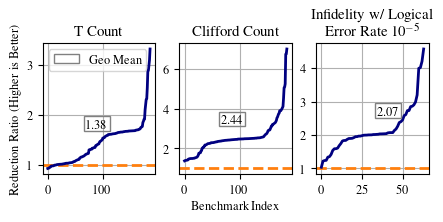

In [21]:
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(
    1,
    3,
    figsize=(SINGLE_WIDTH * 1.25, SINGLE_WIDTH * GOLDEN_RATIO),
    layout="constrained",
)
for i, ylabel in enumerate(["T Count", "Clifford Count", f"Noisy Infidelity 1e-05"]):
    metric = np.concatenate(
        [datafile[dataset][ylabel.lower().replace(" ", "_")] for dataset in datasets],
        axis=1,
    )
    # plt.figure(figsize=(SINGLE_WIDTH / 1.5, SINGLE_WIDTH * GOLDEN_RATIO))
    # if i == 2:
    #     y = np.log(metric[0]) / np.log(metric[1])
    # else:
    y = metric[1] / metric[0]
    y = np.sort(y[np.isfinite(y)])
    geomean = np.exp(np.mean(np.log(y)))
    print(geomean)
    geomean_position = np.where(y > geomean)[0][0]
    xrange = len(y)
    yrange = np.max(y) - np.min(y)
    ax[i].text(
        geomean_position,
        geomean + yrange / 8,
        f"{geomean:.2f}",
        ha="center",
        va="bottom",
        color="black",
        # fontsize=8,
        zorder=6,
    )
    ax[i].add_patch(
        Rectangle(
            (geomean_position - xrange / 8, geomean + yrange / 8),
            xrange / 4,
            yrange / 8,
            color="grey",
            # alpha=0.2,
            edgecolor="black",
            facecolor="none",
            lw=1,
            fill=False,
            label="Geo Mean" if i == 0 else "",
            zorder=5,
        )
    )
    ax[i].axhline(1, linestyle="--", color="tab:orange", linewidth=2)
    ax[i].plot(y, color="navy", linewidth=2)
    if "Infidelity" in ylabel:
        ax[i].set_title("Infidelity w/ Logical\nError Rate $10^{{-5}}$")
    else:
        ax[i].set_title(ylabel)
    # plt.ylim(0, 6.5)
    ax[i].grid()
ax[1].set_xlabel("Benchmark Index")
ax[0].set_ylabel("Reduction Ratio (Higher is Better)")
ax[0].legend()
if SAVE_FIG:
    fig.savefig(f"{SAVE_DIR}/s_curve_intro.pdf")

PyZX

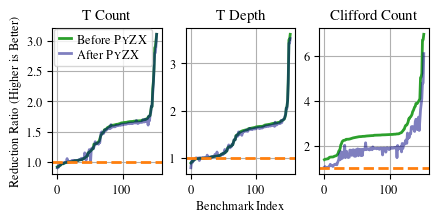

In [ ]:
fig, ax = plt.subplots(
    1,
    3,
    figsize=(SINGLE_WIDTH * 1.25, SINGLE_WIDTH * GOLDEN_RATIO),
    layout="constrained",
)
for i, label in enumerate(["T Count", "T Depth", "Clifford Count"]):
    for j, (ylabel, color) in enumerate(
        zip(
            ["Optimized " + label, label, "Optimized " + label],
            [None, "tab:green", "navy"],
        )
    ):
        metric = np.concatenate(
            [
                datafile[dataset][ylabel.lower().replace(" ", "_")]
                for dataset in datasets
            ],
            axis=1,
        )
        y = metric[1] / metric[0]
        if j == 0:
            mask = np.nonzero(np.isfinite(y))[0]
        elif j == 1:
            mask = mask[np.argsort(y[mask])]
            ax[i].plot(
                y[mask], color=color, linewidth=2, label=f"Before \\textsc{{PyZX}}"
            )
        else:
            y = y[mask]
            x = np.nonzero(np.isfinite(y))[0]
            ax[i].plot(
                x,
                y[x],
                color=color,
                linewidth=2,
                label=f"After \\textsc{{PyZX}}",
                alpha=0.5,
            )
    ax[i].axhline(1, linestyle="--", color="tab:orange", linewidth=2)
    ax[i].title.set_text(label)
    ax[i].grid()
ax[0].legend(
    loc="upper left",
    handlelength=1,
    handletextpad=0.5,
    labelspacing=0.3,
    borderaxespad=0.1,
)
ax[1].set_xlabel("Benchmark Index")
ax[0].set_ylabel("Reduction Ratio (Higher is Better)")
if SAVE_FIG:
    fig.savefig(f"{SAVE_DIR}/s_curve_pyzx.pdf")

Infidelity with Logical Errors

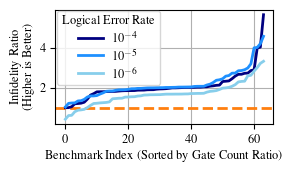

In [104]:
plt.figure(figsize=(0.85 * SINGLE_WIDTH, 0.85 * SINGLE_WIDTH * GOLDEN_RATIO))
plt.axhline(1, linestyle="--", color="tab:orange", linewidth=2)
for e, color in zip(logical_errors[::-1], ["skyblue", "dodgerblue", "navy"][::-1]):
    metric = np.concatenate(
        [datafile[dataset][f"noisy_infidelity_{e}"] for dataset in datasets],
        axis=1,
    )
    # y = np.log(metric[0]) / np.log(metric[1])
    y = metric[1] / metric[0]
    gate_count = np.concatenate(
        [datafile[dataset][f"gate_count"] for dataset in datasets],
        axis=1,
    )
    order = np.argsort(gate_count[1] / gate_count[0])
    order = np.argsort(y)
    y = y[order][np.isfinite(y[order])]
    plt.plot(y, color=color, label=f"$10^{{{int(np.log10(e))}}}$", linewidth=2)
plt.xlabel("Benchmark Index (Sorted by Gate Count Ratio)")
plt.ylabel("Infidelity Ratio\n(Higher is Better)")
# plt.ylim(0.9, 2.5)
plt.legend(title="Logical Error Rate", borderaxespad=0.1, loc="upper left")
plt.grid()
plt.tight_layout()
if SAVE_FIG:
    plt.savefig(f"{SAVE_DIR}/s_curve_logical_error.pdf")

Combined Bar Plots

1.6416532427120103 1.7196614223939644
1.4639135020215226 3.1052631578947367
1.0948838087852921 3.328258064516129
1.168514608287284 3.0
1.6625188140407485 1.7859312923580277
1.445218027523013 3.9143985952589992
1.1063020392474516 3.491041804910418
1.149101741661213 3.6153846153846154
2.4385713952298675 2.5775712710663097
2.8848195675453474 6.976470588235294
1.7545209936600685 4.5055001542099316
2.430021184036728 6.73224043715847


/tmp/ipykernel_2499/2084502117.py:72: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  Rectangle(


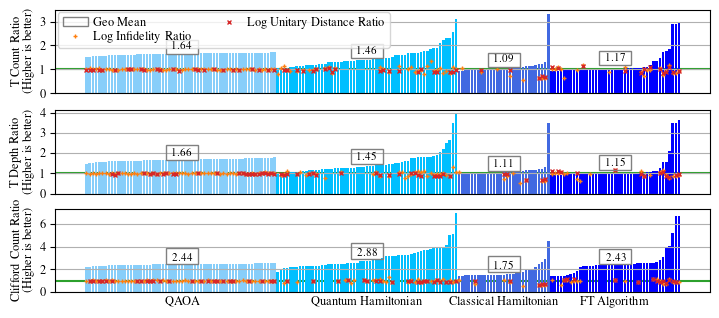

In [98]:
from matplotlib.patches import Rectangle

row = {"category": []}
for dataset in datafile.values():
    for key, value in dataset.items():
        if key not in row:
            row[key] = value
        else:
            row[key] = np.concatenate([row[key], value], axis=-1)
        if key == "name":
            for v in value:
                if "qaoa" in v:
                    row["category"].append("QAOA")
                elif v in ["chemistry", "condensedmatter"]:
                    row["category"].append("Quantum Hamiltonian")
                elif v in ["discreteoptimization", "binaryoptimization"]:
                    row["category"].append("Classical Hamiltonian")
                else:
                    row["category"].append("FT Algorithm")

categories = [
    "QAOA",
    "Quantum Hamiltonian",
    "Classical Hamiltonian",
    "FT Algorithm",
]

fig, ax = plt.subplots(
    3,
    1,
    figsize=(DOUBLE_WIDTH, DOUBLE_WIDTH * GOLDEN_RATIO * 0.7),
    sharex=True,
    layout="constrained",
)
for i, ylabel in enumerate(("T Count", "T Depth", "Clifford Count")):
    metric = row[ylabel.lower().replace(" ", "_")]
    y = metric[1] / metric[0]
    index = 0
    xticks = []

    for j, (cat, color) in enumerate(
        zip(
            categories,
            ["lightskyblue", "deepskyblue", "royalblue", "blue"],
        )
    ):
        mask = np.where(np.array(row["category"]) == cat)
        order = np.argsort(y[mask])
        geomean = np.exp(np.mean(np.log(y[mask])))
        print(geomean, np.max(y[mask]))
        geomean_position = np.where(y[mask][order] > geomean)[0][0] + index
        x = np.arange(index, index + len(mask[0]))
        xticks.append(index + len(mask[0]) // 2)
        index += len(mask[0])
        ax[i].bar(
            x,
            y[mask][order],
            # label=cat,
            color=color,
        )
        ax[i].text(
            xticks[-1],
            geomean + 0.1,
            f"{geomean:.2f}",
            ha="center",
            va="bottom",
            color="black",
            fontsize=8,
            zorder=6,
        )
        ax[i].add_patch(
            Rectangle(
                (xticks[-1] - 5, geomean),
                10,
                (np.max(y) - np.min(y)) / 4,
                color="grey",
                # alpha=0.2,
                edgecolor="black",
                facecolor="none",
                lw=1,
                fill=False,
                label="Geo Mean" if j == 0 else "",
                zorder=5,
            )
        )
        # ax[i].axvline(
        #     geomean_position,
        #     linestyle="--",
        #     color="grey",
        #     label="Geo Mean" if j == 0 else "",
        # )
        ax[i].plot(
            x,
            (np.log2(row["infidelity"][0]) / np.log2(row["infidelity"][1]))[mask][
                order
            ],
            c="tab:orange",
            label="Log Infidelity Ratio" if j == 0 else "",
            linestyle="",
            marker="+",
            markersize=3,
        )
        ax[i].plot(
            x,
            (np.log2(row["distance"][0]) / np.log2(row["distance"][1]))[mask][order],
            c="tab:red",
            label="Log Unitary Distance Ratio" if j == 0 else "",
            linestyle="",
            marker="x",
            markersize=3,
        )
    ax[i].axhline(1, linestyle="-", color="tab:green", zorder=0.5)
    ax[i].set_ylabel(ylabel + " Ratio\n(Higher is better)")
    ax[i].xaxis.set_tick_params(which="both", length=0)
    ax[i].grid(axis="y")

ax[0].legend(
    ncol=2,
    loc="upper left",
    borderaxespad=0.2,
    handletextpad=0.4,
    labelspacing=0.2,
)
# ax[i].set_ylim(0, 4)
# ax[i].set_yticks(range(4))
#     ax[i].set_yticks(range(6))
# ax[i].set_xlabel("Benchmark Index")
# ax[i].set_ylim(0, 5)
ax[2].set_xticks(xticks)
ax[2].set_xticklabels(categories)
ax[0].set_yticks(range(0, 4))
ax[1].set_yticks(range(0, 5))
ax[2].set_yticks(range(0, 7, 2))
if SAVE_FIG:
    fig.savefig(f"{SAVE_DIR}/circuit_benchmark_separately_ordered.pdf")

## Graveyard

Logical Error Rate vs Synthesis Error Threshold (Application)

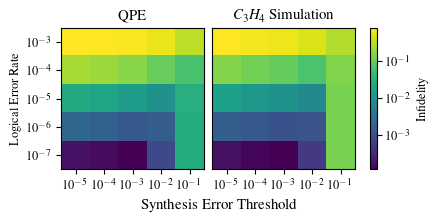

In [ ]:
from utils import find_json_to_read

algorithm = "gridsynth"
zoom = "zoom_out"

fig, ax = plt.subplots(
    1,
    2,
    figsize=(SINGLE_WIDTH * 1.25, SINGLE_WIDTH * GOLDEN_RATIO * 1),
    sharey=True,
    layout="constrained",
)
for i, (_, row) in enumerate(
    find_json_to_read(
        f"{DATA_DIR}/logical_error/{zoom}/{algorithm}", exclude_keywords=["qaoa"]
    )
):
    logical_errors = row["logical_errors"]
    synthesis_thresholds = row["synthesis_errors"]
    logical_errors = [f"$10^{{{int(np.log10(e))}}}$" for e in row["logical_errors"]]
    synthesis_thresholds = [
        f"$10^{{{int(np.log10(e))}}}$" for e in row["synthesis_errors"]
    ]
    im = ax[i].imshow(
        np.log10(1 - np.array(row["fidelity"])).reshape(len(logical_errors), -1),
        aspect="auto",
        origin="lower",
        cmap="viridis",
    )
    ax[i].set_xticks(range(len(synthesis_thresholds)), labels=synthesis_thresholds)
ax[0].set_title("QPE")
ax[1].set_title("$C_3 H_4$ Simulation")
fig.supxlabel("Synthesis Error Threshold")
ax[0].set_yticks(range(len(logical_errors)), labels=logical_errors)
ax[0].set_ylabel("Logical Error Rate")
ax[1].yaxis.set_ticks_position("none")
cbar = fig.colorbar(im, ax=ax.ravel().tolist(), location="right")
cbar.set_label("Infidelity")
cbar.set_ticks(range(-1, -4, -1), labels=[f"$10^{{{e}}}$" for e in range(-1, -4, -1)])
# fig.tight_layout()
if SAVE_FIG:
    fig.savefig(f"{SAVE_DIR}/logical_error_{zoom}_{algorithm}.pdf")

Combined Bar Plots

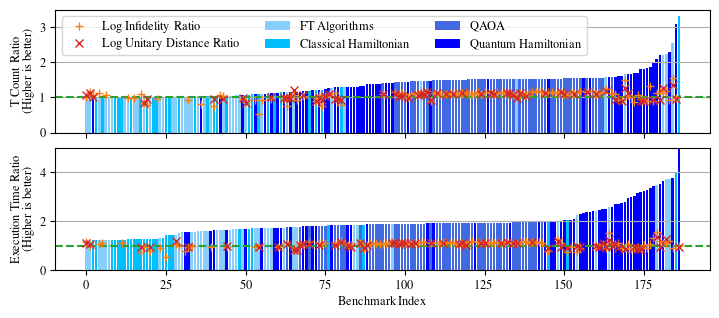

In [ ]:
row = {"category": []}
for dataset in datafile.values():
    for key, value in dataset.items():
        if key not in row:
            row[key] = value
        else:
            row[key] = np.concatenate([row[key], value], axis=-1)
        if key == "name":
            for v in value:
                if "qaoa" in v:
                    row["category"].append("QAOA")
                elif v in ["chemistry", "condensedmatter"]:
                    row["category"].append("Quantum Hamiltonian")
                elif v in ["discreteoptimization", "binaryoptimization"]:
                    row["category"].append("Classical Hamiltonian")
                else:
                    row["category"].append("FT Algorithms")

fig, ax = plt.subplots(
    2,
    1,
    figsize=(DOUBLE_WIDTH, DOUBLE_WIDTH * GOLDEN_RATIO * 0.7),
    sharex=True,
    layout="constrained",
)
for i, (metric, ylabel) in enumerate(
    zip(
        (row["t_count"], row["execution_time"]),
        ("T Count Ratio", "Execution Time Ratio"),
    )
):
    y = metric[1] / metric[0]
    index = np.array(list(range(len(row["name"]))))
    order = np.argsort(y)
    for cat, color in zip(
        [
            "FT Algorithms",
            "Classical Hamiltonian",
            "QAOA",
            "Quantum Hamiltonian",
        ],
        ["lightskyblue", "deepskyblue", "royalblue", "blue"],
        # ["lightskyblue", "royalblue", "blue", "navy"]
    ):
        mask = np.where(np.array(row["category"])[order] == cat)
        ax[i].bar(
            index[mask],
            y[order][mask],
            label=cat,
            color=color,
        )
    ax[i].axhline(1, linestyle="--", color="tab:green")
    ax[i].plot(
        (np.log2(row["infidelity"][0]) / np.log2(row["infidelity"][1]))[order],
        c="tab:orange",
        label="Log Infidelity Ratio",
        linestyle="",
        marker="+",
    )
    ax[i].plot(
        (np.log2(row["distance"][0]) / np.log2(row["distance"][1]))[order],
        c="tab:red",
        label="Log Unitary Distance Ratio",
        linestyle="",
        marker="x",
    )
    ax[i].set_ylabel(ylabel + "\n(Higher is better)")
    if i == 0:
        ax[i].legend(ncol=3)
    #     ax[i].set_yticks(range(4))
    else:
        #     ax[i].set_yticks(range(6))
        ax[i].set_xlabel("Benchmark Index")
        ax[i].set_ylim(0, 5)
    ax[i].grid(axis="y")
    # plt.tight_layout()
if SAVE_FIG:
    fig.savefig(f"{SAVE_DIR}/circuit_benchmark_separately_ordered.pdf")

Synthetiq S Curves

/tmp/ipykernel_1079518/1099912039.py:14: RuntimeWarning: divide by zero encountered in divide
  y = metric[1] / metric[0]
/tmp/ipykernel_1079518/1099912039.py:14: RuntimeWarning: invalid value encountered in divide
  y = metric[1] / metric[0]


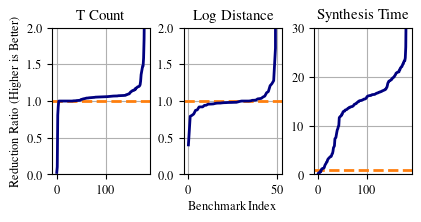

In [ ]:
fig, ax = plt.subplots(
    1,
    3,
    figsize=(SINGLE_WIDTH * 1.2, SINGLE_WIDTH * GOLDEN_RATIO),
    layout="constrained",
)
for i, ylabel in enumerate(["T Count", "Log Distance", "Time"]):
    metric = np.concatenate(
        [
            datafile[dataset][ylabel.lower().replace(" ", "_").replace("log_", "")]
            for dataset in datasets
        ],
        axis=1,
    )
    if "Log" in ylabel:
        y = np.log(metric[0]) / np.log(metric[1])
    else:
        y = metric[1] / metric[0]
    y = np.sort(y[np.isfinite(y)])
    ax[i].axhline(1, linestyle="--", color="tab:orange", linewidth=2)
    ax[i].plot(y, color="navy", linewidth=2)
    ax[i].set_title(ylabel.replace("Time", "Synthesis Time"))
    if i < 2:
        ax[i].set_ylim(0, 2)
    else:
        ax[i].set_ylim(0, 30)
    ax[i].grid()
ax[1].set_xlabel("Benchmark Index")
ax[0].set_ylabel("Reduction Ratio (Higher is Better)")
# fig.tight_layout()
if SAVE_FIG:
    fig.savefig(f"{SAVE_DIR}/s_curve_synthetiq.pdf")

Benchpress Bar Plots

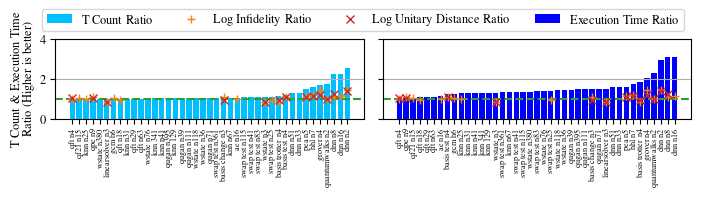

In [ ]:
dataset = "benchpress"
row = datafile[dataset]
colors = ["deepskyblue", "blue"]
fig, ax = plt.subplots(
    1, 2, figsize=(DOUBLE_WIDTH, SINGLE_WIDTH * GOLDEN_RATIO * 0.85), sharey=True
)
for i, (metric, ylabel) in enumerate(
    zip(
        (row["t_count"], row["execution_time"]),
        ("T Count Ratio", "Execution Time Ratio"),
    )
):
    y = metric[1] / metric[0]
    order = np.argsort(y)
    ax[i].bar(
        range(len(row["name"])),
        y[order],
        label=ylabel,
        color=colors[i],
    )
    ax[i].axhline(1, linestyle="--", color="tab:green")
    ax[i].plot(
        (np.log2(row["infidelity"][0]) / np.log2(row["infidelity"][1]))[order],
        c="tab:orange",
        label="Log Infidelity Ratio" if i else None,
        linestyle="",
        marker="+",
    )
    ax[i].plot(
        (np.log2(row["distance"][0]) / np.log2(row["distance"][1]))[order],
        c="tab:red",
        label="Log Unitary Distance Ratio" if i else None,
        linestyle="",
        marker="x",
    )
    ax[i].set_xticks(
        np.arange(len(row["name"])),
        np.array(row["name"])[order],
        rotation=90,
        ha="center",
        fontsize=6,
    )
    ax[i].grid(axis="y")
# ax[0].set_yticks(range(4))
ax[0].set_ylabel("T Count \& Execution Time\nRatio (Higher is better)")
ax[0].set_ylim(0, 4)
fig.legend(ncols=4, bbox_to_anchor=(0.98, 1.1))
fig.tight_layout()
if SAVE_FIG:
    fig.savefig(f"{SAVE_DIR}/circuit_benchmark_{dataset}.pdf", bbox_inches="tight")

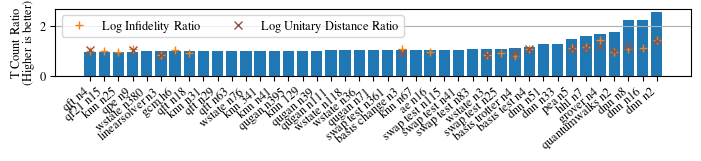

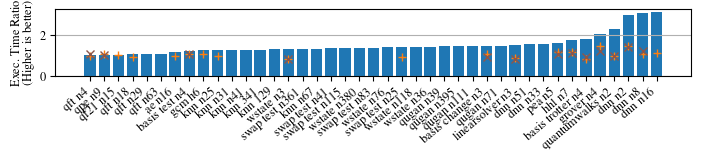

In [ ]:
dataset = "benchpress"
row = datafile[dataset]
for i, (metric, ylabel) in enumerate(
    zip((row["t_count"], row["execution_time"]), ("T Count Ratio", "Exec. Time Ratio"))
):
    plt.figure(figsize=(DOUBLE_WIDTH, SINGLE_WIDTH * GOLDEN_RATIO * 0.8))
    y = metric[1] / metric[0]
    order = np.argsort(y)
    plt.bar(
        range(len(row["name"])),
        y[order],
        # label=ylabel,
    )
    plt.plot(
        (np.log2(row["infidelity"][0]) / np.log2(row["infidelity"][1]))[order],
        c="tab:orange",
        label="Log Infidelity Ratio",
        linestyle="",
        marker="+",
    )
    plt.plot(
        (np.log2(row["distance"][0]) / np.log2(row["distance"][1]))[order],
        c="tab:brown",
        label="Log Unitary Distance Ratio",
        linestyle="",
        marker="x",
    )
    plt.xticks(
        np.arange(len(row["name"])),
        np.array(row["name"])[order],
        rotation=40,
        ha="right",
        # fontsize=6,
    )
    plt.ylabel(ylabel + "\n(Higher is better)")
    if i == 0:
        plt.legend(ncols=2)
    plt.grid(axis="y")
    plt.tight_layout()
    if SAVE_FIG:
        plt.savefig(
            f"{SAVE_DIR}/circuit_benchmark_{dataset}_{ylabel.lower().replace(' ', '_')}.pdf"
        )

Hamlib Bar Plots

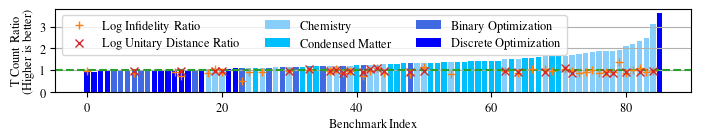

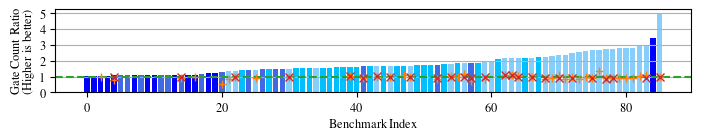

In [ ]:
dataset = "hamlib"
row = datafile[dataset]
for i, (metric, ylabel) in enumerate(
    zip((row["t_count"], row["execution_time"]), ("T Count Ratio", "Exec. Time Ratio"))
):
    plt.figure(figsize=(DOUBLE_WIDTH, SINGLE_WIDTH * GOLDEN_RATIO * 0.7))
    y = metric[1] / metric[0]
    index = np.array(list(range(len(row["name"]))))
    order = np.argsort(y)
    for cat, color in zip(
        [
            "Chemistry",
            "Condensed Matter",
            "Binary Optimization",
            "Discrete Optimization",
        ],
        ["lightskyblue", "deepskyblue", "royalblue", "blue"],
    ):
        mask = np.where(np.array(row["name"])[order] == cat.lower().replace(" ", ""))
        plt.bar(
            index[mask],
            y[order][mask],
            label=cat,
            color=color,
        )
    plt.axhline(1, linestyle="--", color="tab:green")
    plt.plot(
        (np.log2(row["infidelity"][0]) / np.log2(row["infidelity"][1]))[order],
        c="tab:orange",
        label="Log Infidelity Ratio",
        linestyle="",
        marker="+",
    )
    plt.plot(
        (np.log2(row["distance"][0]) / np.log2(row["distance"][1]))[order],
        c="tab:red",
        label="Log Unitary Distance Ratio",
        linestyle="",
        marker="x",
    )
    plt.ylabel(ylabel + "\n(Higher is better)")
    if i == 0:
        plt.legend(ncol=3)
        plt.yticks(range(4))
    else:
        plt.yticks(range(6))
    plt.xlabel("Benchmark Index")
    # plt.ylim(0, 5)
    plt.grid(axis="y")
    plt.tight_layout()
    if SAVE_FIG:
        plt.savefig(
            f"{SAVE_DIR}/circuit_benchmark_{dataset}_{ylabel.lower().replace(' ', '_')}.pdf"
        )

QAOA

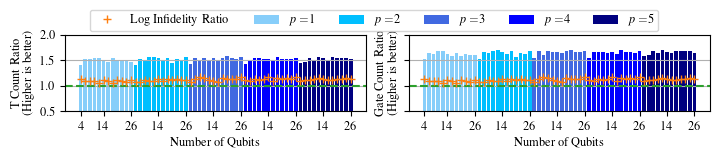

In [ ]:
dataset = "qaoa"
row = datafile[dataset]
fig, ax = plt.subplots(
    1,
    2,
    figsize=(DOUBLE_WIDTH, SINGLE_WIDTH * GOLDEN_RATIO * 0.6),
    sharey=True,
    layout="constrained",
)
for i, (metric, ylabel) in enumerate(
    zip((row["t_count"], row["gate_count"]), ("T Count Ratio", "Gate Count Ratio"))
):
    y = metric[1] / metric[0]
    for p, color in zip(
        range(1, 6),
        ["lightskyblue", "deepskyblue", "royalblue", "blue", "navy"],
    ):
        mask = np.arange(len(qubit_pool) * (p - 1), len(qubit_pool) * p)
        ax[i].bar(
            index[mask],
            y[mask],
            label=f"$p=${p}" if i else None,
            color=color,
        )
    ax[i].axhline(1, linestyle="--", color="tab:green")
    ax[i].plot(
        (np.log2(row["infidelity"][0]) / np.log2(row["infidelity"][1])),
        c="tab:orange",
        label="Log Infidelity Ratio" if i else None,
        linestyle="",
        marker="+",
    )
    ax[i].set_xticks([0] + list(range(5, 60, 6)), labels=[4] + [14, 26] * 5)
    ax[i].set_ylabel(ylabel + "\n(Higher is better)")
    ax[i].set_ylim(0.5, 2)
    ax[i].set_xlabel("Number of Qubits")
    ax[i].grid(axis="y")
fig.legend(ncol=7, bbox_to_anchor=(0.93, 1.18))
# fig.tight_layout()
if SAVE_FIG:
    fig.savefig(f"{SAVE_DIR}/circuit_benchmark_{dataset}.pdf", bbox_inches="tight")

Scatter Plot of Circuit Fidelity vs Number of Qubits

In [ ]:
for ylabel in [
    "Infidelity",
    # "Distance",
]:
    fig, ax = plt.subplots(
        1,
        2,
        figsize=(SINGLE_WIDTH * 1.25, SINGLE_WIDTH * GOLDEN_RATIO),
        sharey=True,
        layout="constrained",
    )
    for i, (xlabel, xkey) in enumerate(
        zip(["Qubits", "Rotations"], ["n", "num_rotations"])
    ):
        for dataset in datasets:
            ax[i].semilogy(
                datafile[dataset][xkey][0],
                datafile[dataset][ylabel.lower()][0],
                marker=".",
                linestyle="None",
                label=dataset if i == 0 else None,
                alpha=0.65,
            )
        ax[i].set_xlabel(f"Number of {xlabel}")
        ax[i].grid()
    fig.legend(loc="center right", bbox_to_anchor=(0.98, 0.38))
    ax[0].set_ylabel(ylabel)
    # fig.tight_layout()
    if SAVE_FIG:
        fig.savefig(f"{SAVE_DIR}/{ylabel.lower()}_scatter.pdf")

Number of Unique Matrices vs T Count

/tmp/ipykernel_2159628/2666730147.py:11: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 2**16.5)


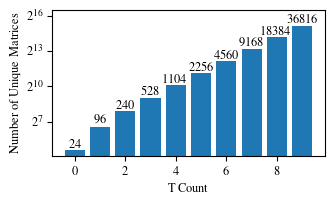

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(1 * SINGLE_WIDTH, 1 * SINGLE_WIDTH * GOLDEN_RATIO))
index = np.arange(10)
y = 72 * 2**index - 48
plt.bar_label(plt.bar(index, y))
plt.semilogy(base=2)
plt.xlabel("T Count")
plt.ylabel("Number of Unique Matrices")
plt.ylim(0, 2**16.5)
plt.tight_layout()
if SAVE_FIG:
    savepath = f"{SAVE_DIR}/num_unique_matrices.pdf"
    os.makedirs(os.path.dirname(savepath), exist_ok=True)
    plt.savefig(savepath)

Sweep of Gridsynth Suboptimal Cases

In [50]:
from itertools import product
from math import pi
import subprocess
import json
import numpy as np

angle_pool = np.linspace(0, 2 * pi, 1000)
eps_pool = np.outer([10**d for d in range(-6, -1)], np.arange(1, 10)).flatten()

In [ ]:
t_counts, lower_bounds = [], []
for angle, eps in product(angle_pool, eps_pool):
    output = subprocess.run(
        [f"./gridsynth.exe", str(angle), "-e", str(eps), "-sp"],
        capture_output=True,
        text=True,
    ).stdout.splitlines()
    for i, metric in enumerate((t_counts, lower_bounds)):
        metric.append(int(output[i + 2].split(": ")[-1]))
t_counts = np.array(t_counts).reshape(len(angle_pool), len(eps_pool))
lower_bounds = np.array(lower_bounds).reshape(len(angle_pool), len(eps_pool))

with open(f"../data/gridsynth_sweep.json", "w") as f:
    json.dump(
        {
            "t_counts": t_counts.tolist(),
            "lower_bounds": lower_bounds.tolist(),
            "angle_pool": angle_pool.tolist(),
            "eps_pool": eps_pool.tolist(),
        },
        f,
    )

In [ ]:
with open(f"../data/gridsynth_sweep.json", "r") as f:
    datafile = json.load(f)
    t_counts = np.array(datafile["t_counts"])
    lower_bounds = np.array(datafile["lower_bounds"])

/tmp/ipykernel_635812/2410525102.py:4: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(t_counts - lower_bounds), aspect="auto")


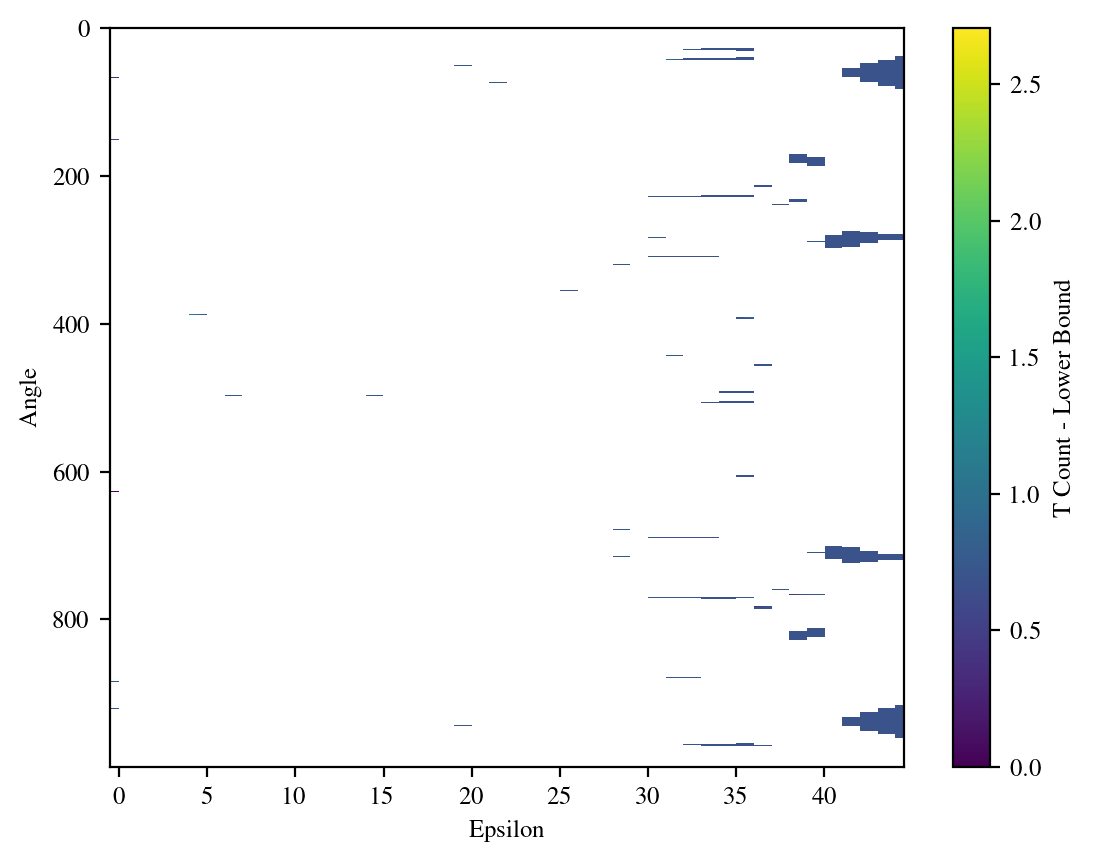

In [48]:
import matplotlib.pyplot as plt

plt.figure(dpi=200)
plt.imshow(np.log(t_counts - lower_bounds), aspect="auto")
plt.xlabel("Epsilon")
plt.ylabel("Angle")
plt.colorbar(label="T Count - Lower Bound")

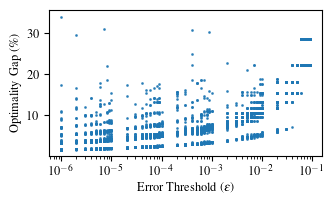

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(SINGLE_WIDTH, SINGLE_WIDTH * GOLDEN_RATIO))
# plt.scatter(np.repeat(eps_pool, 1000), (t_counts - lower_bounds).T, s=3)
# plt.semilogx(eps_pool, np.mean((t_counts - lower_bounds) / (lower_bounds + 1), axis=0))
# plt.semilogx(eps_pool, np.count_nonzero(t_counts - lower_bounds, axis=0) / len(angle_pool))
normalized_diff = [
    100 * a[np.nonzero(a)] / b[np.nonzero(a)]
    for a, b in zip((t_counts - lower_bounds).T, lower_bounds.T)
]
bp = plt.scatter(
    np.repeat(eps_pool, [a.size for a in normalized_diff]),
    np.concatenate(normalized_diff),
    s=1,
    alpha=0.8,
    # c="black",
)
plt.semilogx()
# plt.xticks(ticks=np.arange(5) * 10, labels=[f"$10^{{{d}}}$" for d in range(-6, -1)])
plt.xlabel("Error Threshold ($\\epsilon$)")
plt.ylabel("Optimality Gap (\%)")
# plt.ylabel("Percentage of Suboptimal Solutions")
# plt.legend([bp['medians'][0], bp['means'][0]], ['median', 'mean'])
plt.tight_layout()
if SAVE_FIG:
    plt.savefig(f"{SAVE_DIR}/gridsynth_sweep.pdf")